Clasificación del dataset IRIS usando un estimador lineal
===

* *30 min* | Última modificación: Abril 6, 2020.

## Importación de librerías

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print(tf.__version__)

#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.1.0


## Carga y configuración del dataset

In [3]:
col_names = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth", "Species"]

target_dimensions = ["Setosa", "Versicolor", "Virginica"]

training_data_path = tf.keras.utils.get_file(
    "iris_ training.csv",
    "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv",
)

test_data_path = tf.keras.utils.get_file(
    "iris_test.csv",
    "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv",
)

training = pd.read_csv(training_data_path, names=col_names, header=0)
training = training[training["Species"] >= 1]
training["Species"] = training["Species"].replace([1, 2], [0, 1])
training.reset_index(drop=True, inplace=True)

test = pd.read_csv(test_data_path, names=col_names, header=0)
test = test[test["Species"] >= 1]
test["Species"] = test["Species"].replace([1, 2], [0, 1])
test.reset_index(drop=True, inplace=True)

df = pd.concat([training, test], axis=0)
df.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,6.262000,2.872000,4.906000,1.676000,0.500000
std,0.662834,0.332751,0.825578,0.424769,0.502519
min,4.900000,2.000000,3.000000,1.000000,0.000000
25%,5.800000,2.700000,4.375000,1.300000,0.000000
50%,6.300000,2.900000,4.900000,1.600000,0.500000
75%,6.700000,3.025000,5.525000,2.000000,1.000000
max,7.900000,3.800000,6.900000,2.500000,1.000000


## Exploración del dataset

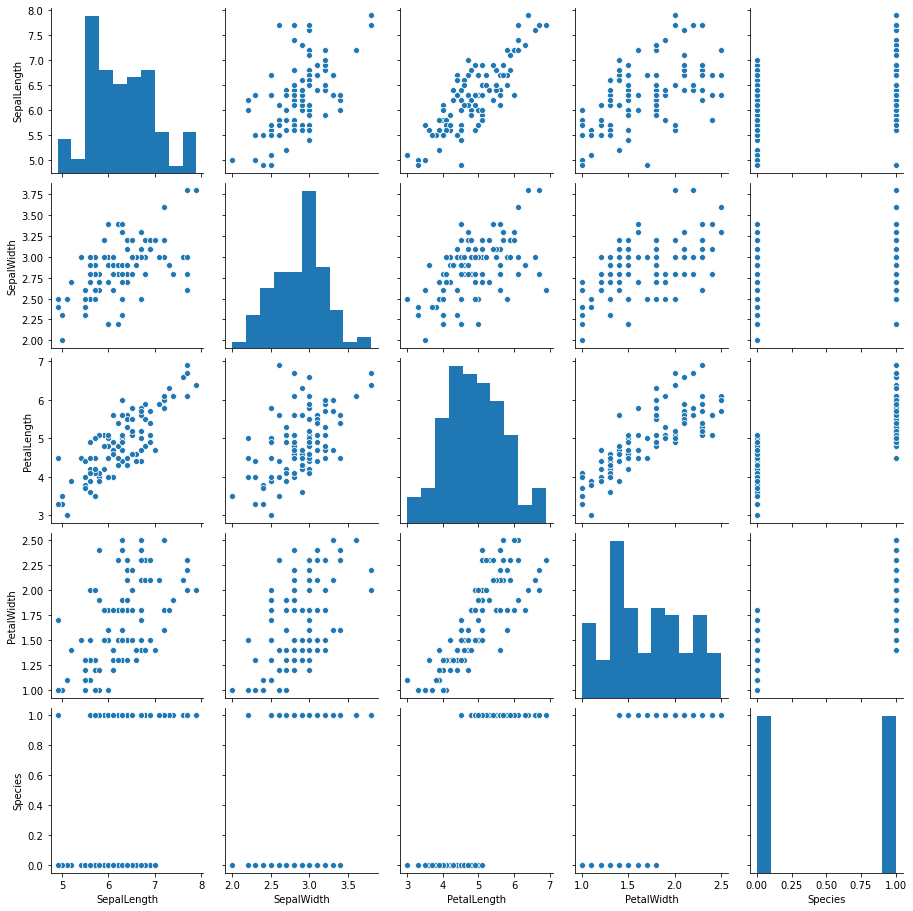

In [4]:
sb.pairplot(df, diag_kind="auto")

In [5]:
df.corr().style.background_gradient(cmap="coolwarm", axis=None)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
SepalLength,1.000000,0.553855,0.828479,0.593709,0.494305
SepalWidth,0.553855,1.000000,0.519802,0.566203,0.308080
PetalLength,0.828479,0.519802,1.000000,0.823348,0.786424
PetalWidth,0.593709,0.566203,0.823348,1.000000,0.828129
Species,0.494305,0.308080,0.786424,0.828129,1.000000


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SepalLength,100.0,6.262,0.662834,4.9,5.800,6.3,6.700,7.9
SepalWidth,100.0,2.872,0.332751,2.0,2.700,2.9,3.025,3.8
PetalLength,100.0,4.906,0.825578,3.0,4.375,4.9,5.525,6.9
PetalWidth,100.0,1.676,0.424769,1.0,1.300,1.6,2.000,2.5
Species,100.0,0.500,0.502519,0.0,0.000,0.5,1.000,1.0


## Conjuntos de entrenamiento y validación

In [7]:
from sklearn.model_selection import train_test_split

#
#  Partición de los datos. La función retorno un objeto
#  pandas.DataFrame para X y un objeto pandas.Series para
#  y
#
X_train, X_test, y_train, y_test = train_test_split(
    df[[c for c in df.columns if c != "Species"]], df["Species"], test_size=0.2
)

## Escalamiento de los datos

In [8]:
from sklearn import preprocessing

#
#  El preprocesador retorna una numpy.ndarray y debe
#  transformarse nuevamente en un pandas.DataFrame
#
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns).astype(
    np.float32
)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns).astype(
    np.float32
)

## Especificación de los parámetros del estimador

In [9]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds

    return input_function


train_input_fn = make_input_fn(X_train, y_train, num_epochs=1, shuffle=False)

test_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

In [10]:
#
#  Crea una lista con los tipos de las columnas
#  del dataframe de entrada
#
feature_columns = [tf.feature_column.numeric_column(m) for m in X_train.columns]

## Entrenamiento

In [11]:
logistic_model = tf.estimator.LinearClassifier(feature_columns=feature_columns)
logistic_model.train(train_input_fn)

## Pronósticos

In [12]:
train_predictions = logistic_model.predict(train_input_fn)
train_predictions = pd.Series(
    [p["classes"][0].decode("utf-8") for p in train_predictions]
)

test_predictions = logistic_model.predict(test_input_fn)
test_predictions = pd.Series(
    [p["classes"][0].decode("utf-8") for p in test_predictions]
)

## Métricas de error

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


def calculate_errors_and_r2(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred.astype("int64"))
    precision = precision_score(y_true, y_pred.astype("int64"))
    recall = recall_score(y_true, y_pred.astype("int64"))
    return accuracy, precision, recall


(
    train_accuracy_score,
    train_precision_score,
    train_recall_score,
) = calculate_errors_and_r2(y_train, train_predictions)

(
    test_accuracy_score,
    test_precision_score,
    test_recall_score,
) = calculate_errors_and_r2(y_test, test_predictions)

print("Training Data Accuracy = ", train_accuracy_score)
print("Training Data Score = ", train_precision_score)
print("Training Data Recall = ", train_recall_score)
print()
print("Testing Data Accuracy = ", test_accuracy_score)
print("Testing Data Score = ", test_precision_score)
print("Testing Data Recall = ", test_recall_score)

Training Data Accuracy =  0.875
Training Data Score =  0.8780487804878049
Training Data Recall =  0.8780487804878049

Testing Data Accuracy =  0.95
Testing Data Score =  1.0
Testing Data Recall =  0.8888888888888888
